<a href="https://colab.research.google.com/github/furusawa-ryoji/MNIST/blob/develop/%E6%96%87%E5%AD%97%E8%AA%8D%E8%AD%98%E3%80%80MNIST_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kaggleの評価
データセットは1枚の画像のピクセルが784(28*28)列で表現されている(0,1で白黒判定かどうかはまだ調べていないがおそらくそう)

提出方法はIdとテストデータを予測した手書き文字の2列のCSVファイル

評価方法はどれだけ予想した手書き文字が合っているかで判定(97%正答なら0.97と表示)
一番いいのは1.00

In [1]:
# ZIPファイル解凍
!unzip digit*

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
import numpy as np

# データの読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(42000, 785)
(28000, 784)


In [3]:
# データの確認
train_df.info

<bound method DataFrame.info of        label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0          1       0       0       0  ...         0         0         0         0
1          0       0       0       0  ...         0         0         0         0
2          1       0       0       0  ...         0         0         0         0
3          4       0       0       0  ...         0         0         0         0
4          0       0       0       0  ...         0         0         0         0
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
41995      0       0       0       0  ...         0         0         0         0
41996      1       0       0       0  ...         0         0         0         0
41997      7       0       0       0  ...         0         0         0         0
41998      6       0       0       0  ...         0         0         0         0
41999      9       0       0       0  ...         0         0     

In [4]:
# データフレームを配列に出来ているか確認
train_data = np.array(train_df)
test = np.array(test_df)
print(train_data)
print(test)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
# ラベルと目的変数の定義
label = train_data[:, 0]
train = train_data[:,1:]
del train_data
print(train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


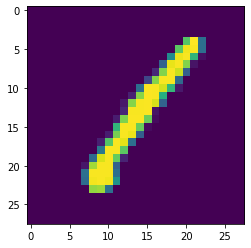

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train[0].reshape(28,28))

In [7]:
# 画像は1行→28*28*1(3次元)にreshapeする必要がある
train = train.reshape(-1, 28, 28, 1).astype('float32')
test = test.reshape(-1, 28, 28, 1).astype('float32')
# print(train)
# print(test)
print(train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [8]:
# plt.imshow(train[0])

In [9]:
# 同じ画像を3枚重ねて学習データとテストデータ共に3次元にする
# X_train = np.dstack([train, train, train])
# X_test = np.dstack([test, test, test])
# X_train.shape, X_test.shape

In [10]:
# 画像を32x32x3に拡大させる
import cv2
# データのサイズを 28x28x3 -> 32x32x3 に
x_train = []
SIZE = 32
for t_data in train:
  dst = np.dstack((t_data, t_data, t_data))
  dst = cv2.resize(dst,(SIZE, SIZE),interpolation=cv2.INTER_CUBIC)
  x_train.append(dst)

x_test = []
for t_data in test:
  dst = np.dstack((t_data, t_data, t_data))
  dst = cv2.resize(dst,(SIZE, SIZE), interpolation=cv2.INTER_CUBIC)
  x_test.append(dst)
x_train = np.array(x_train)
x_test = np.array(x_test)

print(x_train.shape)
print(x_test.shape)

(42000, 32, 32, 3)
(28000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-6.0959235e-02, -6.0959235e-02, -6.0959235e-02],
        [-2.6247492e+00, -2.6247492e+00, -2.6247492e+00],
        [ 5.9173271e-02,  5.9173271e-02,  5.9173271e-02],
        [ 7.5352318e+01,  7.5352318e+01,  7.5352318e+01],
        [ 2.6379492e+02,  2.6379492e+02,  2.6379492e+02],
        [ 2.5395224e+02,  2.5395224e+02,  2.5395224e+02],
        [ 2.75

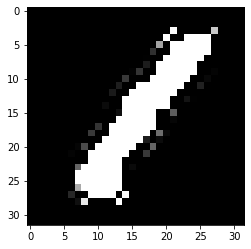

In [11]:
plt.imshow(x_train[0])
x_train[0, 15:20]

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# クロスバリデーション(トレーニングデータを5つに分割)
kf = KFold(n_splits=5, shuffle=True)

# 多クラス分類のときにクラスのラベルをそのまま推論させない
# One-Hot表現に変換し、各クラスに分類される確率を出す。
# 0～9の数字のラベルに分類する？
from keras.utils import to_categorical
y_train = to_categorical(label, 10)

for train_index, eval_index in kf.split(x_train):
    X_tra, X_eval = x_train[train_index], x_train[eval_index]
    y_tra, y_eval = y_train[train_index], y_train[eval_index]

# データを正規化
x_tra = X_tra / 255
x_eval = X_eval / 255

In [13]:
x_tra.shape

(33600, 32, 32, 3)

In [14]:
print(y_train)
print(y_train.shape)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(42000, 10)


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# 画像の表示:imshow(行)→28*28にすればいいのではないか？
# plt.imshow(train[300])

In [16]:
# 必要なライブラリをインポート
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7

In [17]:
# 3つのアンサンブルを作成する
NETS = 3
NET = NETS -1
model = [0] *NETS
for j in range(NET):
    # モデルを作成：精度を上げるためにはここが一番重要
    # アンサンブルで同じモデルを複数作成
    model[j] = Sequential()
    model[j].add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(SIZE, SIZE, 3)))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))

    model[j].add(Conv2D(64, (3, 3), activation='relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Dropout(0.25))

    model[j].add(Flatten())
    model[j].add(Dense(512, activation='relu'))
    model[j].add(Dense(10, activation='softmax'))

    # 学習のためのモデルを設定
    model[j].compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=0.002),
                  metrics=['accuracy'])

model[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [18]:
# 転移学習でEfficientNetB7のモデルを作成
base_model = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(SIZE, SIZE, 3),
    classes=10
)

model[NET] = Sequential()
model[NET].add(base_model)
model[NET].add(Dropout(0.25))

model[NET].add(Flatten())
model[NET].add(Dense(512, activation='relu'))
model[NET].add(Dense(10, activation='softmax'))

# 学習のためのモデルを設定
model[NET].compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.002),
              metrics=['accuracy'])

model[NET].summary()

258080768/258076736 [==============================] - 11s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 1, 1, 2560)        64097687  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 2560)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1311232   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 65,414,049
Trainable params: 65,103,322
Non-trainable params: 310,727
_________________________________________________________________


In [19]:
# データ拡張により画像をさらに作成
datagen = ImageDataGenerator(
        # rotation_range: 整数．画像をランダムに回転する回転範囲．
        rotation_range=10,  
        # zoom_range: 浮動小数点数または[lower，upper]．ランダムにズームする範囲．浮動小数点数が与えられた場合，[lower, upper] = [1-zoom_range, 1+zoom_range]
        zoom_range = 0.10,  
        # width_shift_range: 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲．
        width_shift_range=0.1, 
        # height_shift_range: 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲．
        height_shift_range=0.1)

In [20]:
# 画像データをImageDataGeneratorに食わせることで画像の水増し
datagen.fit(x_tra)

In [21]:
# 学習率減衰：学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.002
    if epoch >= 10:
        x = 0.001
    if epoch >= 30:
        x = 0.0005
    return x

lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=1,
)

In [22]:
# 学習
result = [0] * NETS
for j in range(NETS):
  result[j] = model[j].fit_generator(datagen.flow(x_tra, y_tra),
            epochs=8,
            validation_data=(x_eval, y_eval),
            callbacks=[lr_decay]
            )
  # 精度を検証
  model[j].evaluate(x_eval, y_eval)
  print('')

# 学習状況のログを表示
history = result[NET].history
print(history.keys())

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002.
Epoch 1/8
1050/1050 [==============================] - 27s 26ms/step - loss: 2.0249 - accuracy: 0.3145 - val_loss: 0.9229 - val_accuracy: 0.7494

Epoch 00002: LearningRateScheduler reducing learning rate to 0.002.
Epoch 2/8
1050/1050 [==============================] - 27s 26ms/step - loss: 1.1856 - accuracy: 0.6080 - val_loss: 0.4742 - val_accuracy: 0.8686

Epoch 00003: LearningRateScheduler reducing learning rate to 0.002.
Epoch 3/8
1050/1050 [==============================] - 27s 25ms/step - loss: 0.8719 - accuracy: 0.7198 - val_loss: 0.3021 - val_accuracy: 0.9239

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002.
Epoch 4/8
1050/1050 [==============================] - 26s 25ms/step - loss: 0.6265 - accuracy: 0.8048 - val_loss: 0.2199 - val_accuracy: 0.9448

Epoch 00005: LearningRateScheduler reducing learning rate to 0.002.

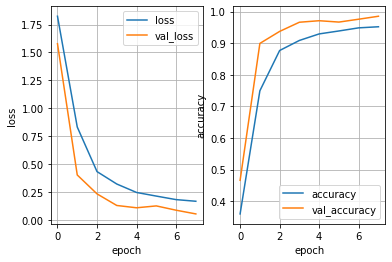

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# 学習曲線を表示する→どうやって表示させるんだっけ？historyをインスタンス化して列名取得じゃダメなの？
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(history['loss'], label='loss')
ax1.plot(history['val_loss'], label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(history['accuracy'], label='accuracy')
ax2.plot(history['val_accuracy'], label='val_accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
ax2.grid()

In [45]:
# model[0].predict(test)
test.shape

(28000, 28, 28, 1)

In [46]:
x_test.shape

(28000, 32, 32, 3)

In [47]:
# テストデータの予測
results = np.zeros((test.shape[0],10)) 
for j in range(NETS):
    results = results + model[j].predict(x_test)
# カテゴリー分類されたテストデータの最大値のインデックス(右から順に数えて何番目かを返す)
results = np.argmax(results,axis = 1)
# npの配列のままなので、データフレームの形に直して名前を付ける
results = pd.Series(results, name="Label")
# 一応できているか確認
print(results)
print(results.shape)

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("CNN_submission.csv",index=False)

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64
(28000,)


In [48]:
sub_df = pd.read_csv('CNN_submission.csv')
print(sub_df.shape)
print(sub_df)

(28000, 2)
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
